Let's investigate the relationship between dicision scores and misclassified sediments. To see if thse misclassified sediments are the result of our machine's "hesitation."

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
#mpl.rcParams['xtick.labelsize'] = 8
#mpl.rcParams["image.cmap"] = 'gray'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

# Read the optimal model and data
We know the optimal model is trained by SVC using the rolling data. However, there are multiple models built in different time. 

roll_svc_trainn_model_20210511.joblib: it's the model using the same parameters as the optimal modle before we seperated the data into training, dev and test sets (roll_svc_model_20201120.joblib) to train on the training set.<br> 
roll_svc_model_20210524.joblib: it's the model built by redoing the grid searching on the training set. Therefore, its parameters are different from roll_svc_trainn_model_20210511.joblib.<br>
roll_svc_model_20210621.joblib: it's the model built by training on the training and dev sets. 

The model roll_svc_trainn_model_20210511.joblib is used to visualize the confidence scores previous (ML_element_07.ipynb and prepare_paper.ipynb). I think it's better to use roll_svc_model_20210524.joblib since it's more fit to the training set and our workflow.

In [2]:
from joblib import load
svc = load('models/roll_svc_model_20210524.joblib')

from split import my_train_test_split
data_df = pd.read_csv('data/XRF_ML_cr.csv')
X = data_df.iloc[:, 1:-2].values
y = data_df['facies_merge_2'].values
groups = data_df['core_section'].values

train_idx, test_idx = my_train_test_split(y, groups)
# This time I split the training set again to obtain dev set
trainn_idx, dev_idx = my_train_test_split(y[train_idx], groups[train_idx])
X_dev = X[train_idx[dev_idx]]
y_dev = y[train_idx[dev_idx]]
groups_dev = groups[train_idx[dev_idx]]
del X, y, groups, data_df

In [3]:
facies = ['shoreface', 'channel', 'beach-foreshore', 'sand flat', 'mud flat',
       'lagoon', 'peat', 'soil', 'eolian/fluvial (W)',
       'shallow marine', 'moraine', 'eolian/fluvial']

Facies = []
for fa in facies:
    Facies.append(fa.capitalize())

Facies

['Shoreface',
 'Channel',
 'Beach-foreshore',
 'Sand flat',
 'Mud flat',
 'Lagoon',
 'Peat',
 'Soil',
 'Eolian/fluvial (w)',
 'Shallow marine',
 'Moraine',
 'Eolian/fluvial']

# Produce the decision scores

In [4]:
# these two sections are in the dev set
dec = svc.decision_function(X_dev)
y_pred = svc.predict(X_dev)

In [5]:
print(X_dev.shape)
print(np.hstack([X_dev, y_dev.reshape(-1, 1)]).shape)
print(np.hstack([X_dev, y_dev.reshape(-1, 1), groups_dev.reshape(-1, 1)]).shape)
print(np.hstack([
    X_dev, y_dev.reshape(-1, 1),
    y_pred.reshape(-1, 1),
    dec, 
    groups_dev.reshape(-1, 1)
    ]).shape)

(21608, 24)
(21608, 25)
(21608, 26)
(21608, 39)


In [6]:
compile_df = pd.DataFrame(
    np.hstack([
        groups_dev.reshape(-1, 1),
        y_dev.reshape(-1, 1),
        y_pred.reshape(-1, 1),
        dec
        ]),
    columns=np.hstack([['core_section', 'y', 'y_pred'], Facies])
)
compile_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21608 entries, 0 to 21607
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   core_section        21608 non-null  object
 1   y                   21608 non-null  object
 2   y_pred              21608 non-null  object
 3   Shoreface           21608 non-null  object
 4   Channel             21608 non-null  object
 5   Beach-foreshore     21608 non-null  object
 6   Sand flat           21608 non-null  object
 7   Mud flat            21608 non-null  object
 8   Lagoon              21608 non-null  object
 9   Peat                21608 non-null  object
 10  Soil                21608 non-null  object
 11  Eolian/fluvial (w)  21608 non-null  object
 12  Shallow marine      21608 non-null  object
 13  Moraine             21608 non-null  object
 14  Eolian/fluvial      21608 non-null  object
dtypes: object(15)
memory usage: 2.5+ MB


In [7]:
# change dtypes
for col in compile_df.columns[1:]:
    compile_df[col] = pd.to_numeric(compile_df[col])

compile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21608 entries, 0 to 21607
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   core_section        21608 non-null  object 
 1   y                   21608 non-null  int64  
 2   y_pred              21608 non-null  int64  
 3   Shoreface           21608 non-null  float64
 4   Channel             21608 non-null  float64
 5   Beach-foreshore     21608 non-null  float64
 6   Sand flat           21608 non-null  float64
 7   Mud flat            21608 non-null  float64
 8   Lagoon              21608 non-null  float64
 9   Peat                21608 non-null  float64
 10  Soil                21608 non-null  float64
 11  Eolian/fluvial (w)  21608 non-null  float64
 12  Shallow marine      21608 non-null  float64
 13  Moraine             21608 non-null  float64
 14  Eolian/fluvial      21608 non-null  float64
dtypes: float64(12), int64(2), object(1)
memory usage: 2.5

# Visualize scores in section

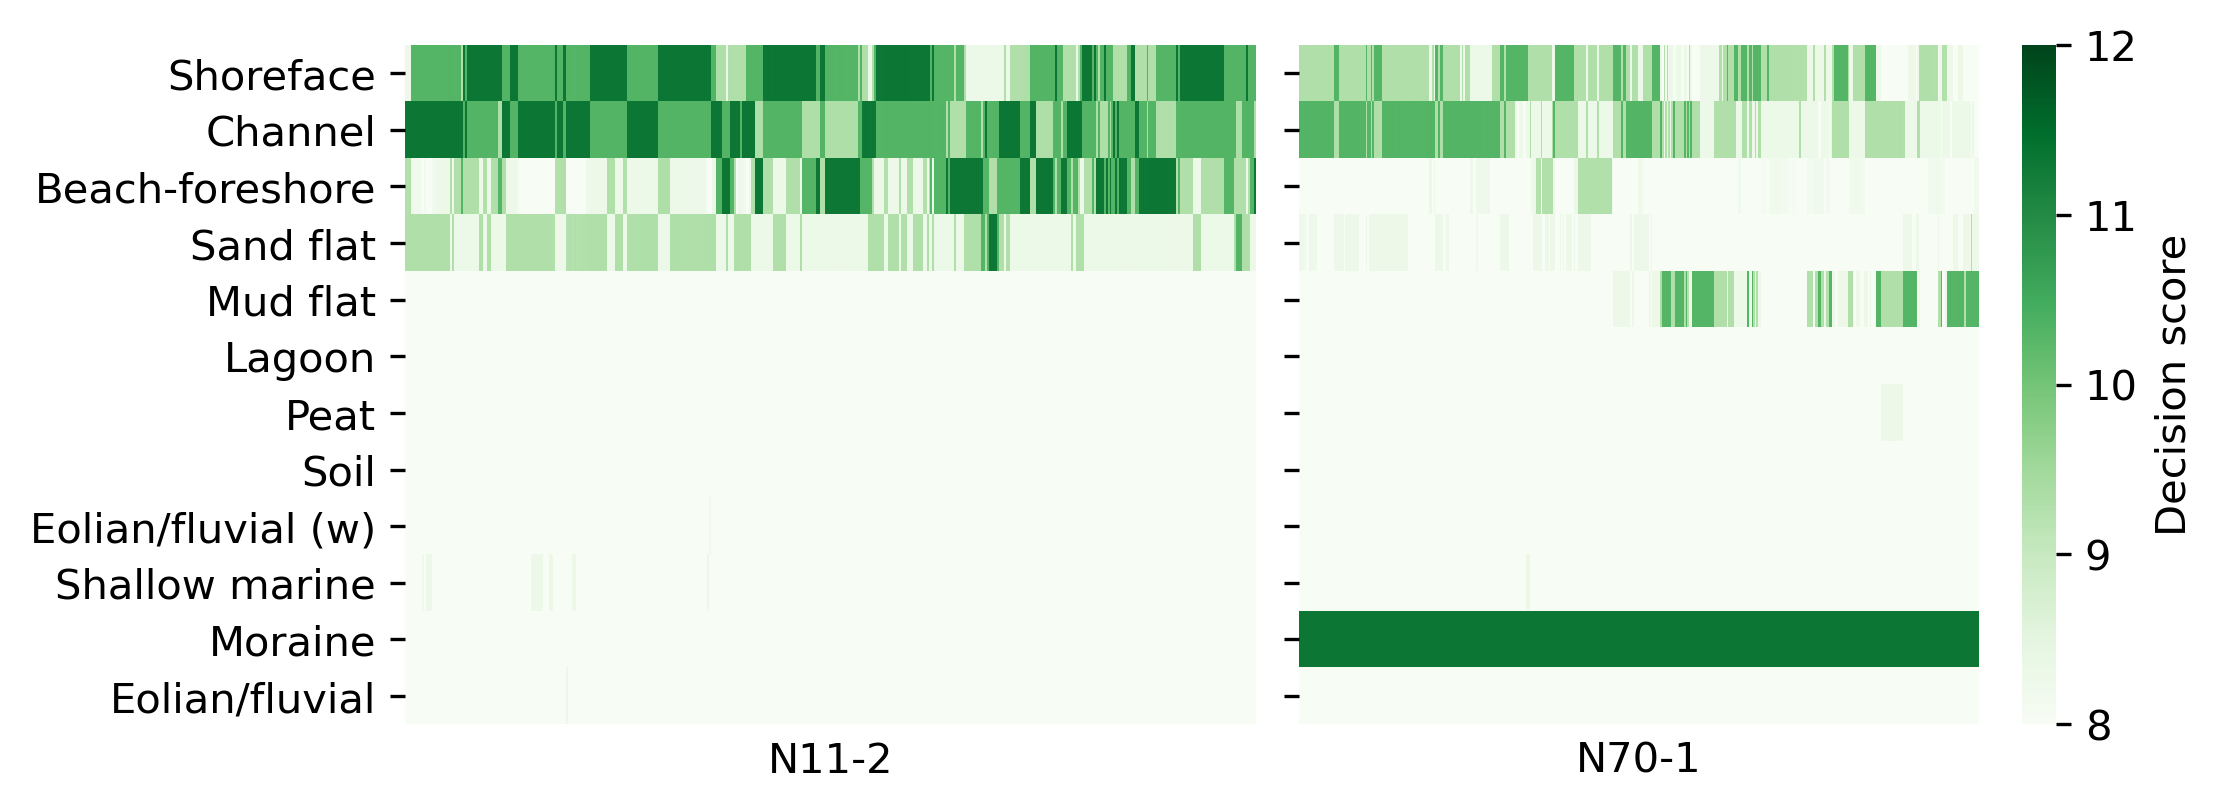

In [30]:
# just to see if the outputs are similar to prepare_paper.ipynb
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3), sharey='row')
sns.heatmap(compile_df.loc[compile_df.core_section == 'N11-2', compile_df.columns[3:]].T, cmap='Greens', yticklabels=Facies, vmax=12, vmin=8, xticklabels=False, ax=axes[0], cbar=False)
sns.heatmap(compile_df.loc[compile_df.core_section == 'N70-1', compile_df.columns[3:]].T, cmap='Greens', yticklabels=Facies, vmax=12, vmin=8, xticklabels=False, ax=axes[1], 
            cbar_kws = {'label' : 'Decision score', 'ticks': [8, 9, 10, 11, 12]})
axes[0].set_xlabel('N11-2')
axes[1].set_xlabel('N70-1')
plt.subplots_adjust(wspace=.05)

# Visualize the property of scores
To see if the misclassified sediments are having multiple similar scores in different facies (i.e. the machine is hesitating). 

## Use statistics
I calculate mean, medain, std and kurtosis of the decision scores in each data point (i.e. sediment). Then I simulate their distribution (KDE) in correctly amd incorrectly classified, respectively.

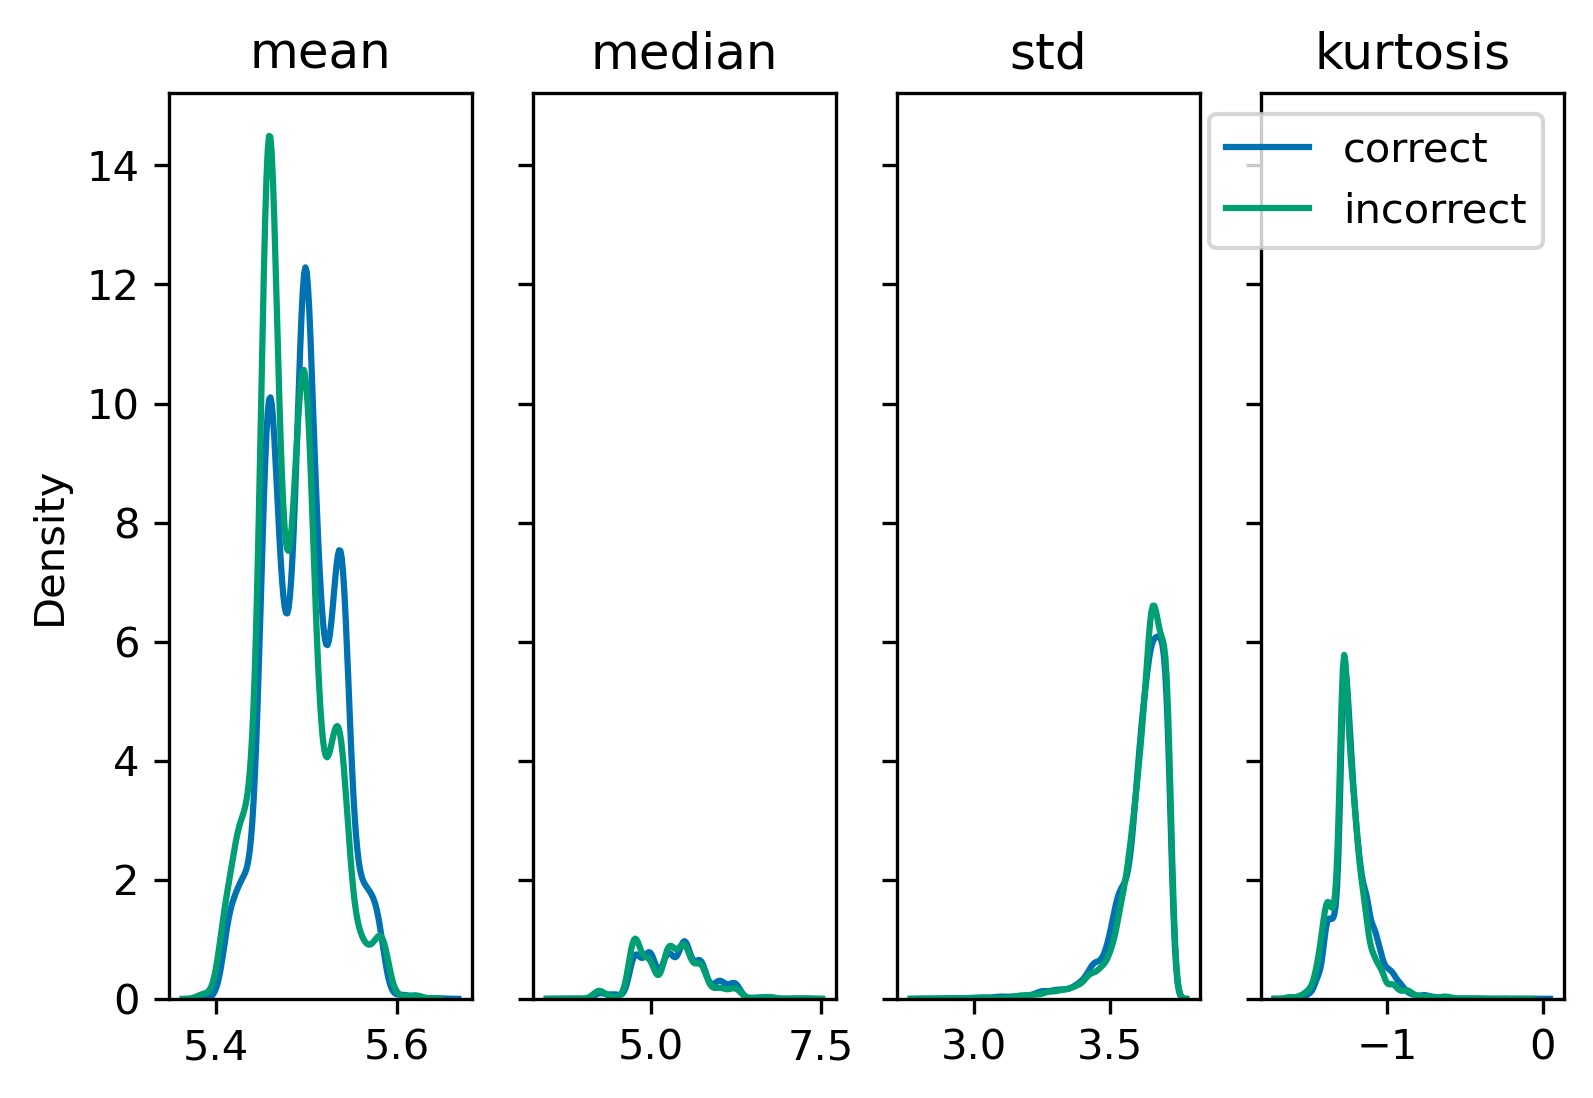

In [28]:
from scipy.stats import kurtosis
mask = compile_df.y == compile_df.y_pred
fig, axes = plt.subplots(1, 4, sharey='row')
for ax, alg in zip(axes, [np.mean, np.median, np.std, kurtosis]):
    a1 = compile_df.loc[mask, compile_df.columns[3:]].apply(alg, axis=1)
    a2 = compile_df.loc[~mask, compile_df.columns[3:]].apply(alg, axis=1)
    sns.kdeplot(a1, label='correct', ax=ax)
    sns.kdeplot(a2, label='incorrect', ax=ax)
    ax.set_title(str(alg).split()[1])
ax.legend()


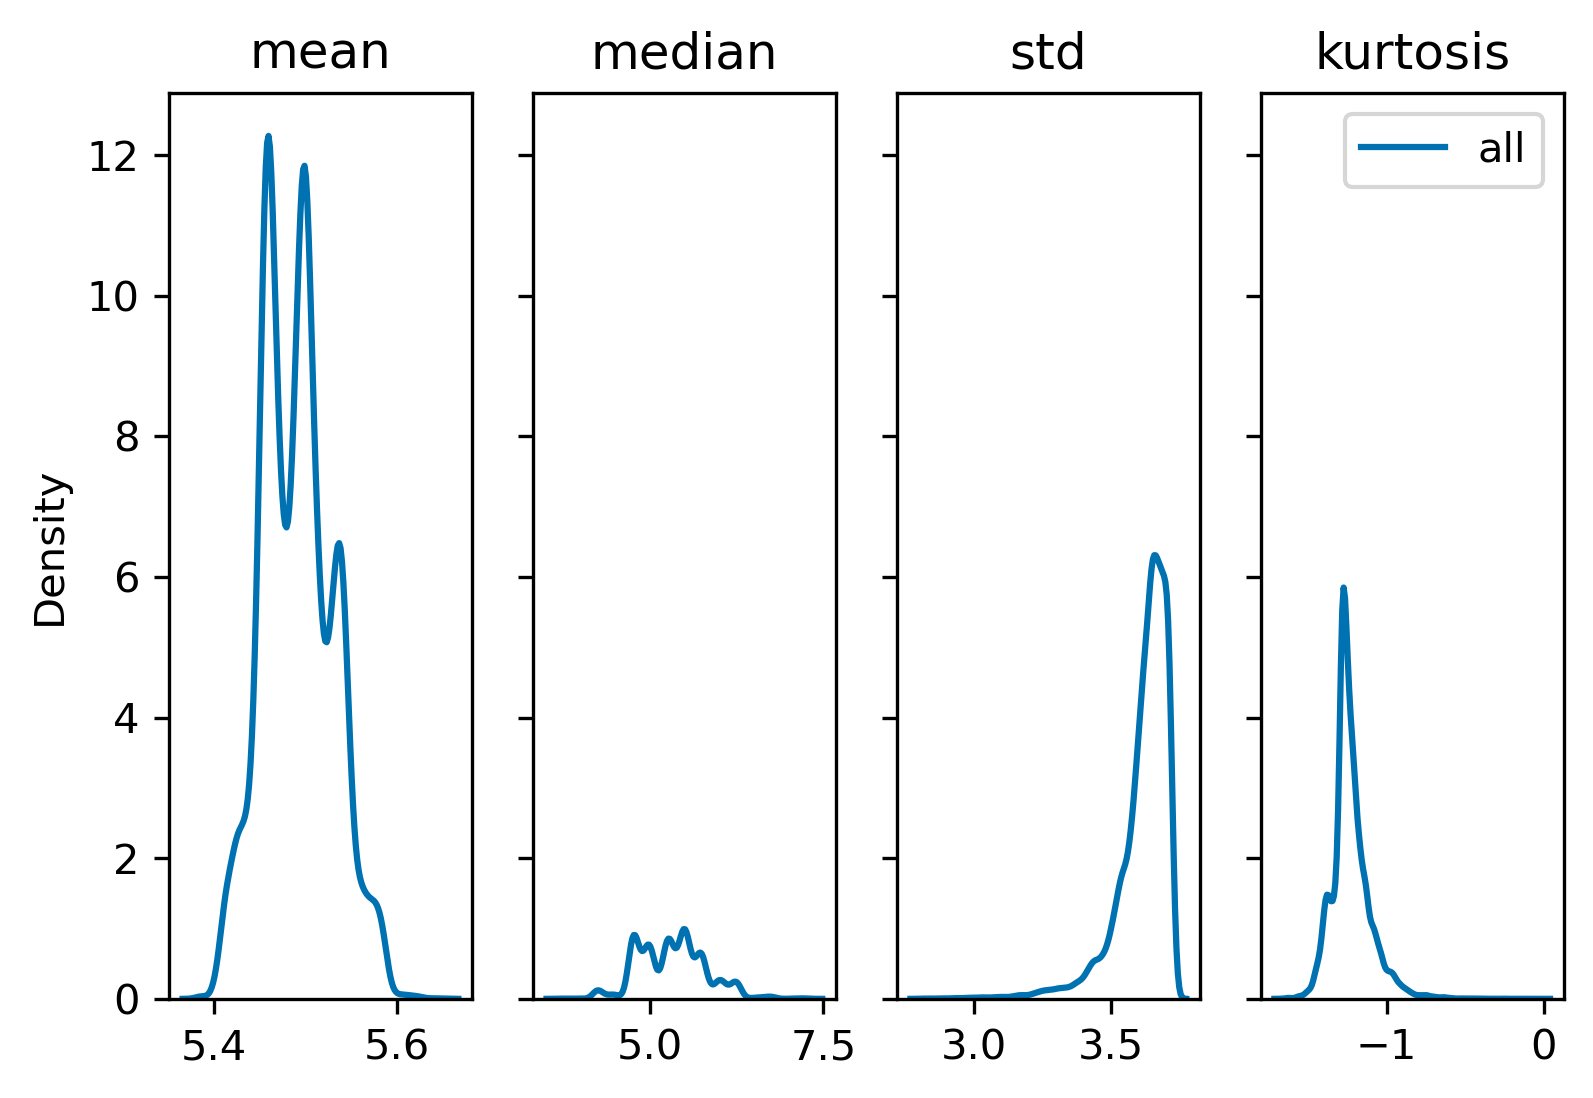

In [29]:
fig, axes = plt.subplots(1, 4, sharey='row')
for ax, alg in zip(axes, [np.mean, np.median, np.std, kurtosis]):
    a1 = compile_df.loc[:, compile_df.columns[3:]].apply(alg, axis=1)
    sns.kdeplot(a1, label='all', ax=ax)
    ax.set_title(str(alg).split()[1])
ax.legend()


I can't see the misclassidied data points have "hesitation" in decision scores comparing to the correcly classified data poits, not even any difference. Even when I look at the whole data points, there is no clear bimodal feature to point out the machine is whether "confident" or "hestating". Or the mean, median, std and kurtosis can't represent the "hesitation" of the decision scores in each data point. But I so far I don't have any idea what other statistic is much suitable.

# Visualize directly
Since the statiscs so far can't give clear difference, let's try visualize the scores directly along the whole data points.

In [67]:
def plot_dec(x, mask, vmax, vmin):
    fig, axes = plt.subplots(1, 2, figsize=(7.5, 3), sharey='row')
    sns.heatmap(x[mask].T, cmap='Greens', yticklabels=Facies, vmax=vmax, vmin=vmin, xticklabels=False, ax=axes[0], cbar=False)
    sns.heatmap(x[~mask].T, cmap='Greens', yticklabels=Facies, vmax=vmax, vmin=vmin, xticklabels=False, ax=axes[1], 
                cbar_kws = {'label' : 'Decision score', 'ticks': np.linspace(vmax, vmin, 5)})
    axes[0].set_xlabel('Data points')
    axes[0].set_title('Correct')
    axes[1].set_xlabel('Data points')
    axes[1].set_title('Incorrect')
    plt.subplots_adjust(wspace=.05)

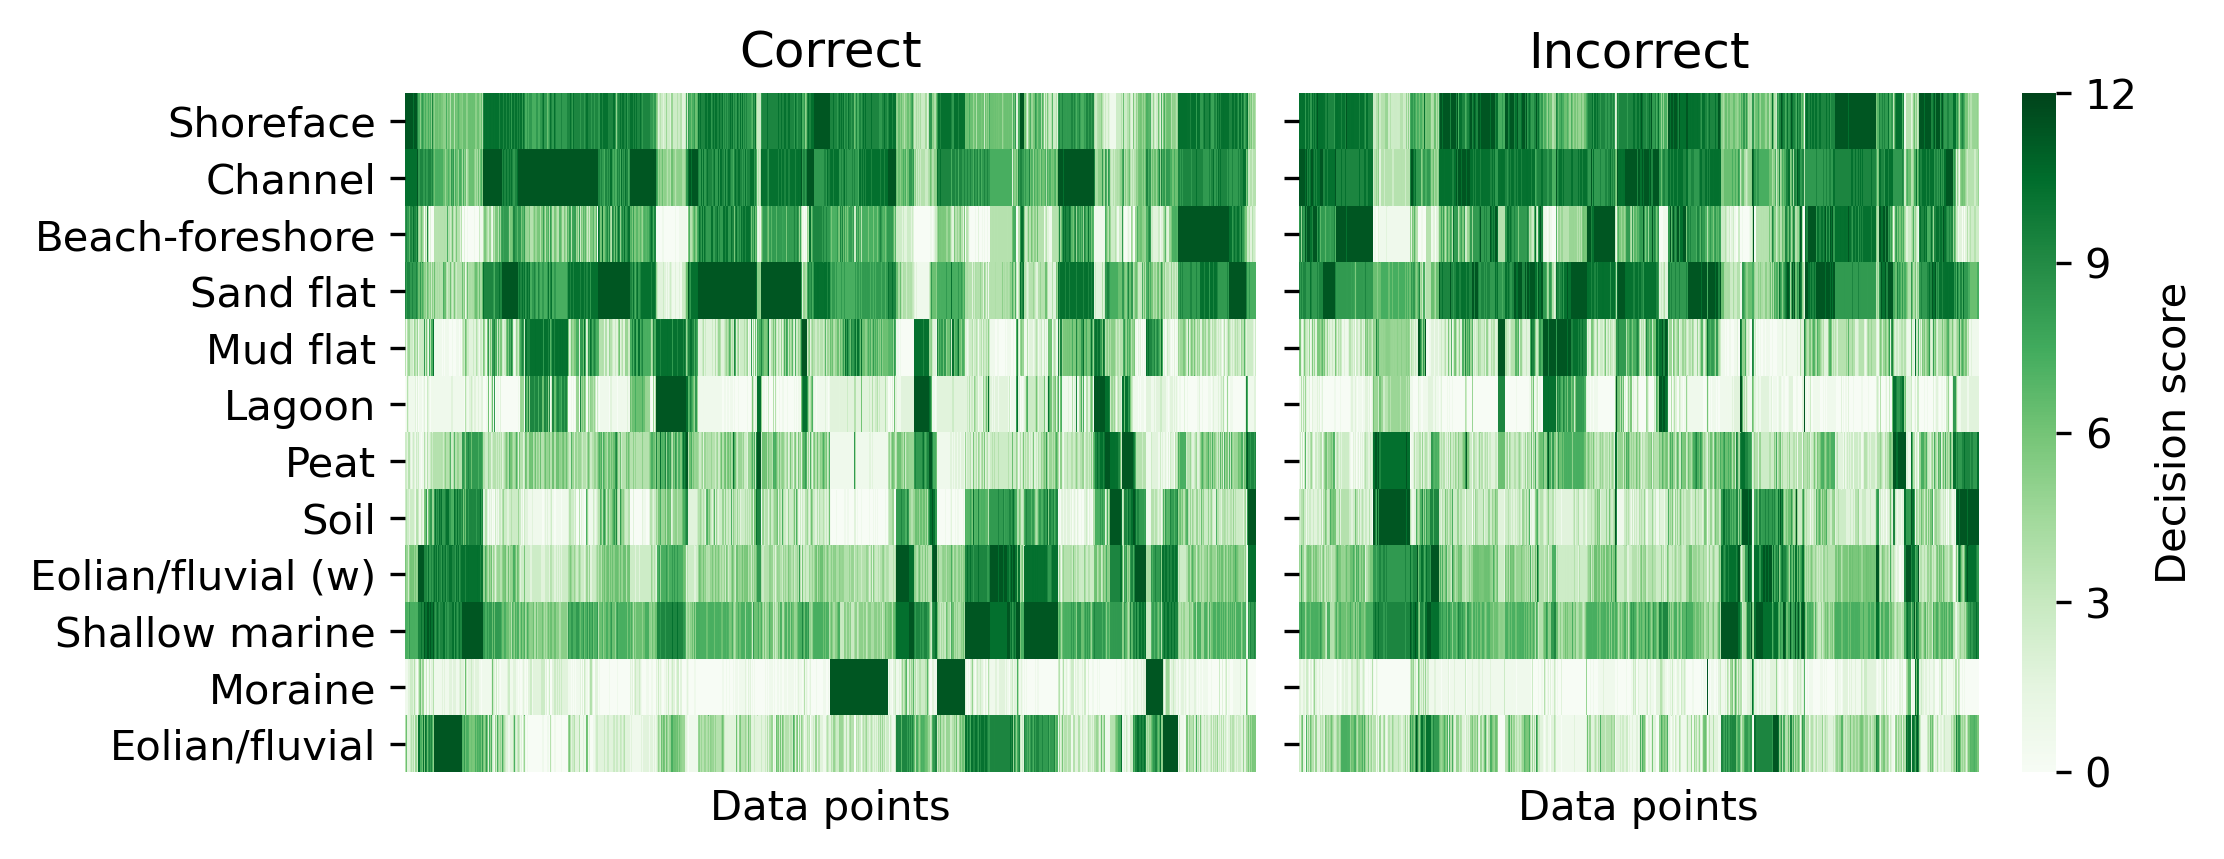

In [68]:
# the whole range of scores
plot_dec(compile_df[compile_df.columns[3:]], mask, 12, 0)

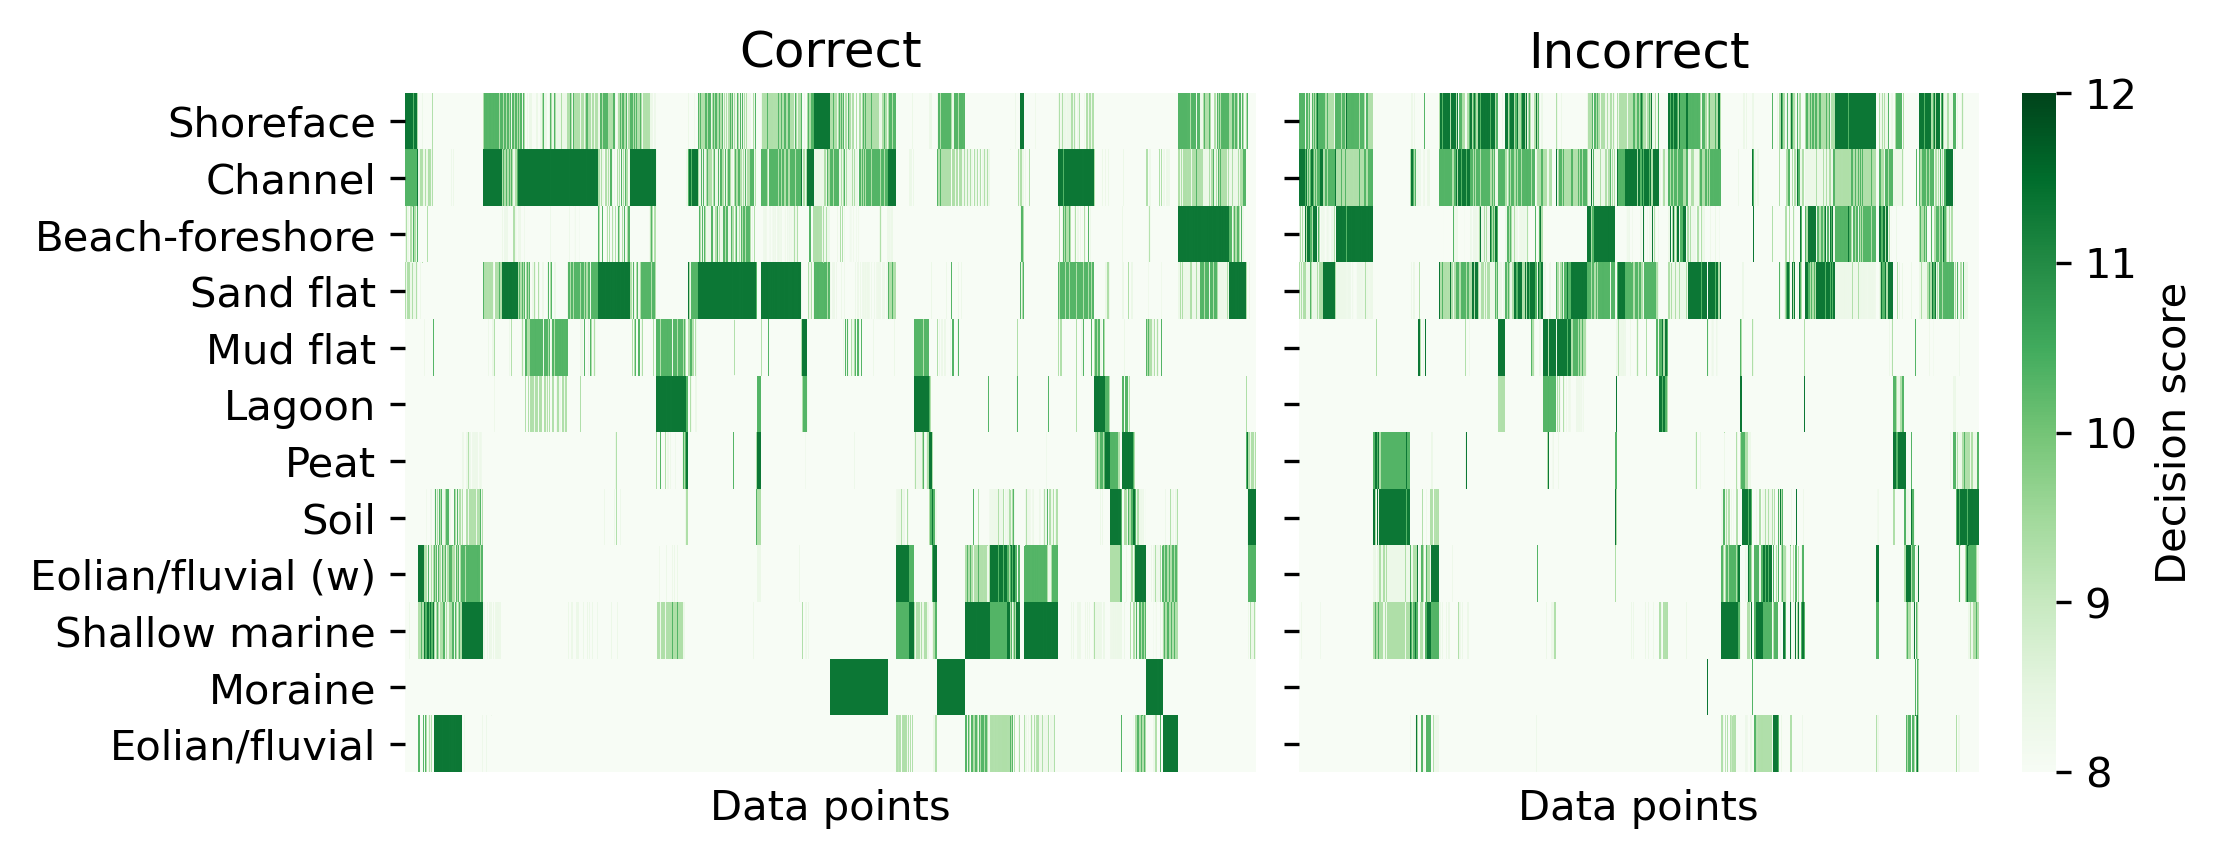

In [69]:
# zoom in to 8-12 score values
plot_dec(compile_df[compile_df.columns[3:]], mask, 12, 8)

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dec_std = scaler.fit_transform(compile_df.iloc[:, 3:])

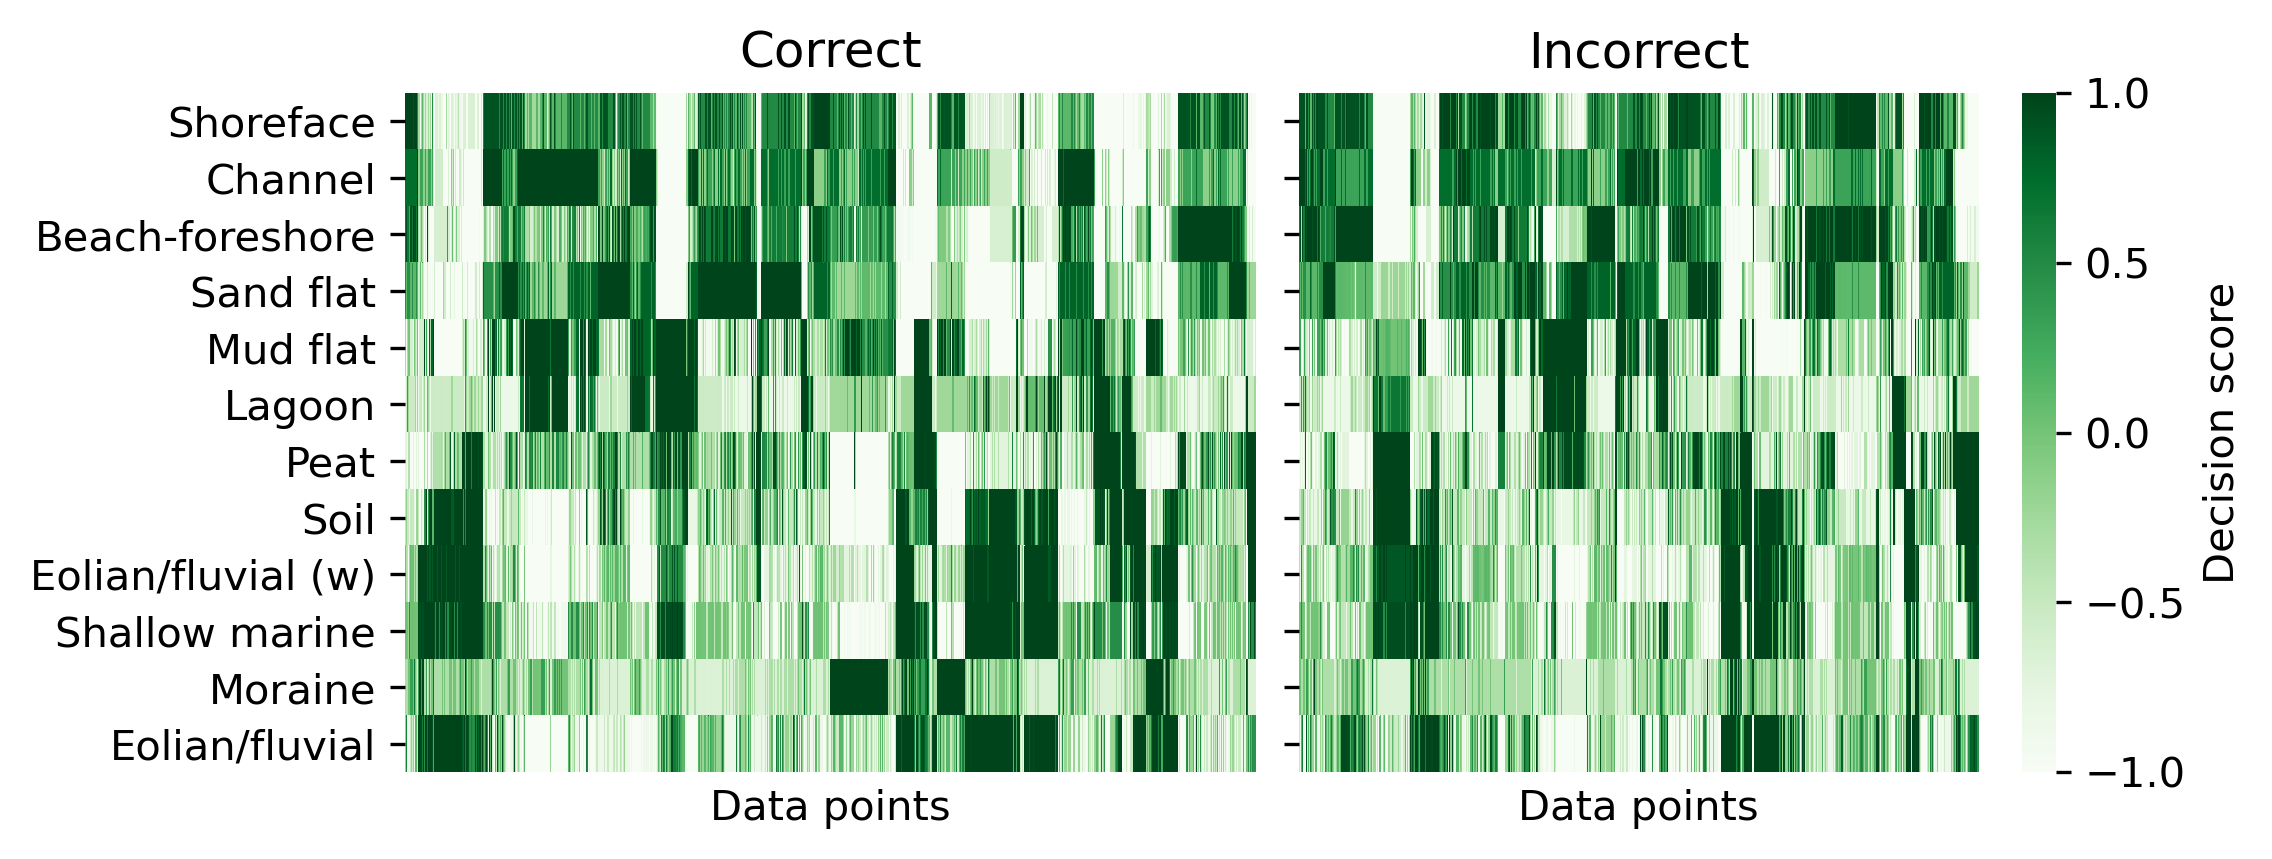

In [70]:
# use the standardized scores
plot_dec(dec_std, mask, 1, -1)

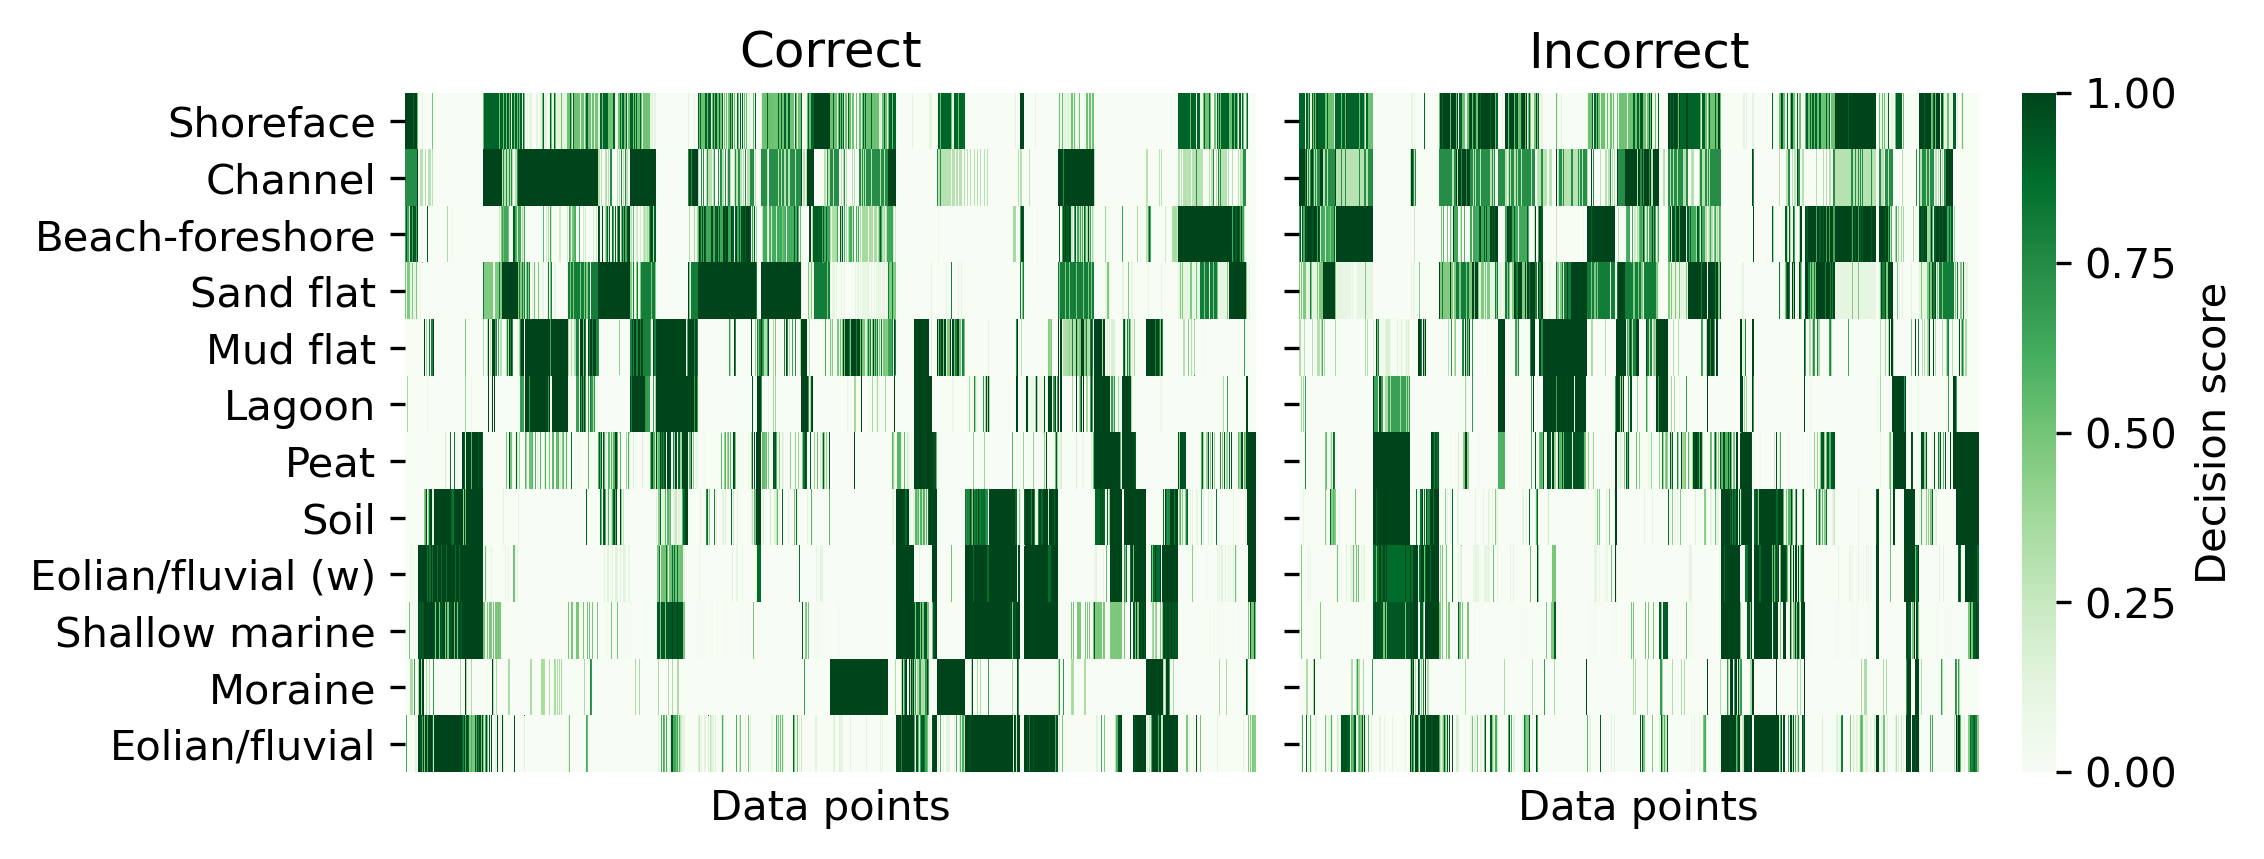

In [72]:
# use the standardized scores
# zoom in
plot_dec(dec_std, mask, 1, 0)

Hmm...the scores can't show the hesitation I expected no mattter how I manage the numbers (zooming in or standardization). I'm disappointed to say the decision scores can't really help us to pinpoint the critical parts. But perhaps the psudo-probability can do the job according to the result in ML_element_07.ipynb (it has the incosistence of prediction, but to show the "hesitation" may be enough.)